# Exploring 55 million rows of NYC Taxi Fare data with efficient memory usage

As a follow up from my previous [kernel](https://www.kaggle.com/szelee/how-to-import-a-csv-file-of-55-million-rows), I proceed to do EDA on the entire 55 million rows of data. 

The main ideas is to load the CSV without the pickup and dropoff coordinates. By selectively choosing the columns during CSV file reading, we can reduce the memory usage and loading time.

I focus on the analysis of monthly taxi ride for this kernel.

TLDR:
1. The test data distribution is quite **different** from training data in terms of monthly total taxi rides. This is not my discovery, I read about it from this [kernel](https://www.kaggle.com/akosciansky/using-ml-for-data-exploration-feat-engineering) by @akosciansky
1. There is a sharp increase in taxi fare from **September 2012** onward. This matches the news of [New York Taxis to Start Charging Increased Rates](https://www.nytimes.com/2012/09/04/nyregion/new-york-taxis-to-start-charging-increased-rates.html)
1. **\$2.50** is the reasonable minimum cut-off point to remove outliers. 
1.  **\$500** is the reasonable maximum cut-off point to remove outliers (further analysis on pickup and dropoff corrdinates should lower this value)
1. Most of the outliers of both maximum and minimum monthly fare lie in the  same periods of time.

# Import libraries

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

In [5]:
PATH = "data/nyc-taxi/"

# Load data csv format
(This section only needs to be executed once! Subsequently, once feather format data is created, jump straight to **Load data feather format** section below which is much faster!

In [6]:
# Set columns to most suitable type to optimize for memory usage, 
# We can also drop passenger_count since it's not used in this kernel, but I just keep it since it uses only uint8
types = {'fare_amount': 'float32',
         'passenger_count': 'uint8'}

# Columns to load for training data
cols_train = ['fare_amount', 'pickup_datetime', 'passenger_count', 'pickup_datetime']

# Columns to load for test data
cols_test = ['pickup_datetime', 'passenger_count']

In [7]:
%%time
i=0
df_list = [] # list to hold the batch dataframe
chunksize = 10_000_000 # 10 million rows at one go. 
for df_chunk in pd.read_csv(f'{PATH}train.csv', usecols=cols_train, dtype=types, chunksize=chunksize):
    
    i = i+1
    print(f'DataFrame Chunk {i}')
    
    # Neat trick from https://www.kaggle.com/btyuhas/bayesian-optimization-with-xgboost
    # Slicing off unnecessary components of the datetime and specifying the date 
    # format results in a MUCH more efficient conversion to a datetime object.
    df_chunk['pickup_datetime'] = df_chunk['pickup_datetime'].str.slice(0, 16)
    df_chunk['pickup_datetime'] = pd.to_datetime(df_chunk['pickup_datetime'], utc=True, format='%Y-%m-%d %H:%M')
    
    df_list.append(df_chunk) 

DataFrame Chunk 1
DataFrame Chunk 2
DataFrame Chunk 3
DataFrame Chunk 4
DataFrame Chunk 5
DataFrame Chunk 6
Wall time: 1min 12s


In [8]:
# Merge all dataframes into one dataframe
train_df = pd.concat(df_list)

del df_list

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55423856 entries, 0 to 55423855
Data columns (total 3 columns):
fare_amount        float32
pickup_datetime    datetime64[ns, UTC]
passenger_count    uint8
dtypes: datetime64[ns, UTC](1), float32(1), uint8(1)
memory usage: 687.1 MB


This has only used less than **700Mb** of memory for the entire **55 million rows** of data.

(Bear in mind that we have purposely ignore pickup and dropoff coordinates for this analysis, otherwise it would consume about **1.5Gb** of memory instead)

As comparison, with eat-all-you-can loading such as:

`train_df =  pd.read_csv('../input/train.csv', nrows = 10_000_000)`

will result in about **610Mb** just for the first **10 million rows**, and 

`train_df =  pd.read_csv('../input/train.csv')`

will consume more than **3Gb** of memory for entire **55 million rows**!

In [9]:
# save both training and test data to feather format
os.makedirs('tmp', exist_ok=True)
train_df.to_feather('tmp/taxi-train-no-gps.feather')

test_df = pd.read_csv(f'{PATH}test.csv', parse_dates=["pickup_datetime"], usecols=cols_test,
                         infer_datetime_format=True, dtype=types)
test_df.to_feather('tmp/taxi-test-no-gps.feather')

# Load data feather format
(begin from here directly once we have the feather format file)

In [10]:
%%time
train_df = pd.read_feather('tmp/taxi-train-no-gps.feather')

Wall time: 649 ms


Notice it took only a few seconds to load the entire dataframe.

In [11]:
test_df = pd.read_feather('tmp/taxi-test-no-gps.feather')

In [12]:
display(train_df.head())
display(train_df.tail())

,fare_amount,pickup_datetime,passenger_count
0,4.5,2009-06-15 17:26:00+00:00,1
1,16.9,2010-01-05 16:52:00+00:00,1
2,5.7,2011-08-18 00:35:00+00:00,2
3,7.7,2012-04-21 04:30:00+00:00,1
4,5.3,2010-03-09 07:51:00+00:00,1


,fare_amount,pickup_datetime,passenger_count
55423851,14.0,2014-03-15 03:28:00+00:00,1
55423852,4.2,2009-03-24 20:46:00+00:00,1
55423853,14.1,2011-04-02 22:04:00+00:00,1
55423854,28.9,2011-10-26 05:57:00+00:00,1
55423855,7.5,2014-12-12 11:33:00+00:00,1


In [13]:
display(test_df.head())
display(test_df.tail())

,pickup_datetime,passenger_count
0,2015-01-27 13:08:24,1
1,2015-01-27 13:08:24,1
2,2011-10-08 11:53:44,1
3,2012-12-01 21:12:12,1
4,2012-12-01 21:12:12,1


,pickup_datetime,passenger_count
9909,2015-05-10 12:37:51,6
9910,2015-01-12 17:05:51,6
9911,2015-04-19 20:44:15,6
9912,2015-01-31 01:05:19,6
9913,2015-01-18 14:06:23,6


# Group and aggregate by year-month

In [14]:
# Group all training data rides by month+year combination and aggregate them by count, mean, median, min and max
fare_grouped_df = train_df.fare_amount.groupby([train_df.pickup_datetime.dt.year,train_df.pickup_datetime.dt.month])

fare_count_df = fare_grouped_df.count()
fare_mean_df = fare_grouped_df.mean()
fare_median_df = fare_grouped_df.median()
fare_min_df = fare_grouped_df.min()
fare_max_df = fare_grouped_df.max()

In [15]:
# for drawing barchart, so we don't have to retype the following everytime
def draw_barchart(df, title):
    fig = plt.figure(figsize=(20, 4))
    ax = fig.add_subplot(111)
    df.plot(kind='bar')
    ax.set_xlabel("(Year, Month)")
    plt.title(title)
    plt.show()

## Monthly ride count

This section is derived from this [kernel](https://www.kaggle.com/akosciansky/using-ml-for-data-exploration-feat-engineering) by @akosciansky

In [16]:
 fare_count_df.describe()

count        78.000000
mean     710562.256410
std       48398.599676
min      557375.000000
25%      683213.250000
50%      714990.500000
75%      743938.000000
max      804979.000000
Name: fare_amount, dtype: float64

We also do the aggregate by count for test data, since we are only concern with the **count** of rides here, not the **fare**. We can then compare this with training data.

In [17]:
test_group_df = test_df.pickup_datetime.groupby([test_df.pickup_datetime.dt.year,test_df.pickup_datetime.dt.month]).count()

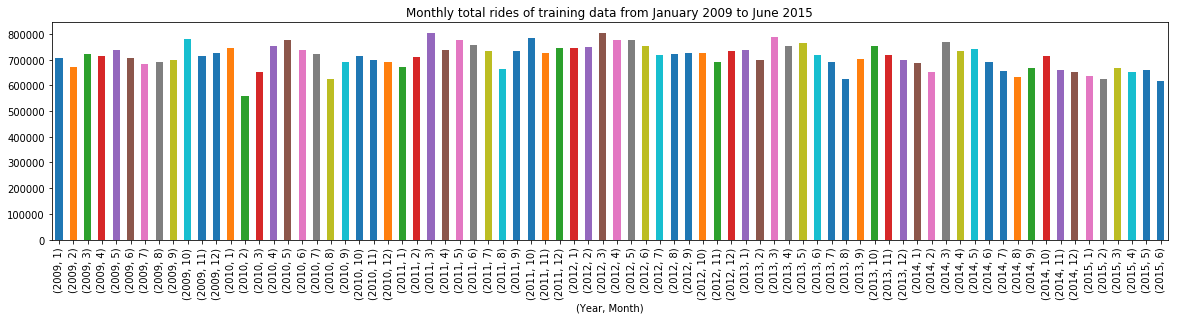

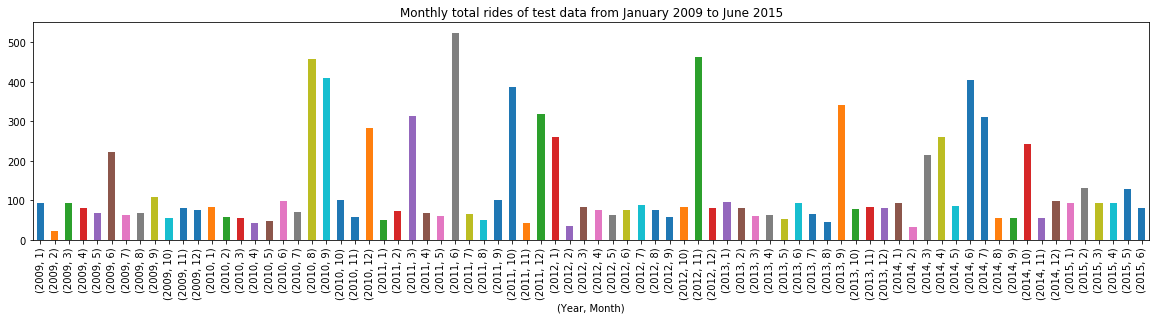

In [18]:
draw_barchart(fare_count_df, 'Monthly total rides of training data from January 2009 to June 2015')
draw_barchart(test_group_df, 'Monthly total rides of test data from January 2009 to June 2015')

While training data barchart has a relative uniform monthly total rides, the test data monthly total rides are not spread evenly, with some random huge spikes. We might need to consider this when we create our validation set.

## Monthly mean fare

In [19]:
fare_mean_df.describe()

count    78.000000
mean     11.367785
std       1.312047
min       9.568311
25%      10.212288
50%      10.659033
75%      12.736461
max      13.684370
Name: fare_amount, dtype: float64

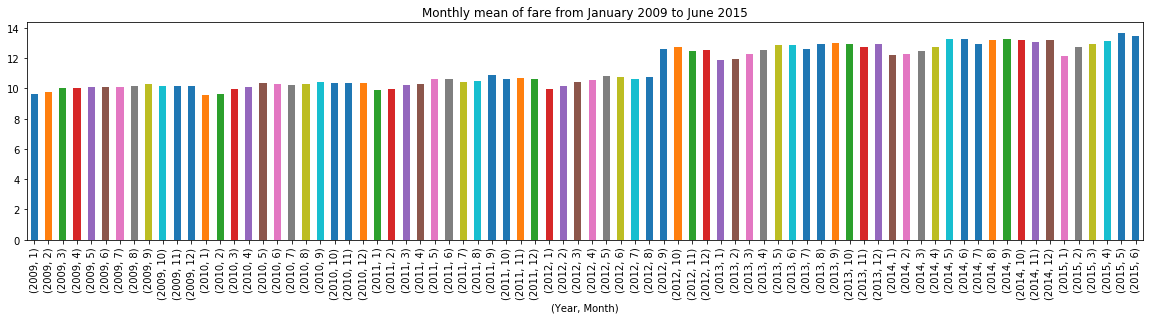

In [20]:
draw_barchart(fare_mean_df,'Monthly mean of fare from January 2009 to June 2015')

From January 2009 until September 2012, the monthly mean fare is quite uniform. 

There is a gradual increase from January until December before it dropped again on January of following year.

However, there is a big jump from October 2012 onwards. The monthly mean fare increased by about \$3 during this period. Probably a price increase at this point onwards.

The pattern where the monthly mean fare drops from December to January remains true during this period.

## Monthly median fare

In [21]:
fare_median_df.describe()

count    78.000000
mean      8.487180
std       0.847205
min       7.300000
25%       7.700000
50%       8.100000
75%       9.500000
max      10.000000
Name: fare_amount, dtype: float64

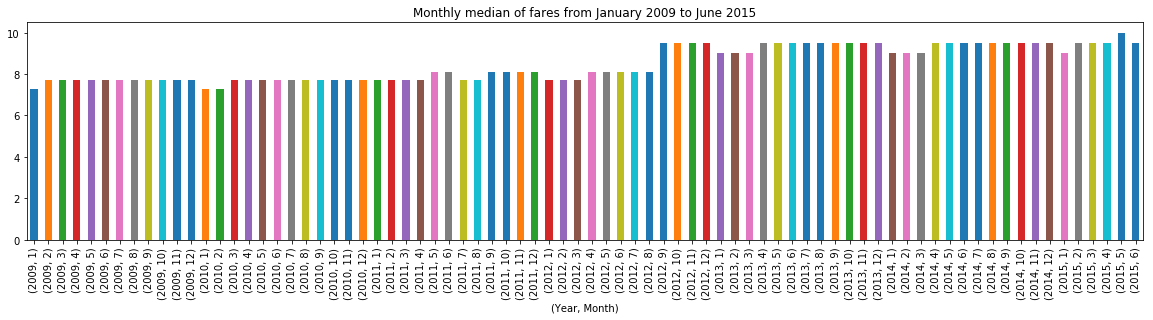

In [22]:
draw_barchart(fare_median_df,'Monthly median of fares from January 2009 to June 2015')

Here we can see the median is relatively uniform from January 2009 to September 2012

Not surprisingly, as we've seen in the monthly mean fare bar chart, there is a big jump from October 2012 onwards. 

The monthly median fare increased permanently by about almost \$2.00 during this period of September 2012 to June 2015.

A quick Google search verifies this:

https://www.nytimes.com/2012/09/04/nyregion/new-york-taxis-to-start-charging-increased-rates.html

One idea is we can create a boolean column based on the month and year to indicate whether it is before or after the price increase. This will help our model to learn better.

## Monthly minimum fare

In [23]:
fare_min_df.describe()

count     78.000000
mean     -15.734744
std       58.026012
min     -300.000000
25%        2.500000
50%        2.500000
75%        2.500000
max        2.500000
Name: fare_amount, dtype: float64

The 25% percentile, 50% percentile (median) and 75% percentile all shows \$2.5. Which is probably the real minimum fare.

Most people just assume the minimum fare of \$0 and drop the negative fares. We need to dig deeper.

In [24]:
fare_min_df.mode()

0    2.5
dtype: float32

Mode value is also \$2.50

In [25]:
# take note that we are checking the fare amount in the original dataframe, not the aggregated one
print(f"Number of rides below $0.00: \t\t{len(train_df.fare_amount[train_df.fare_amount<0])}")
print(f"Number of rides at $0.00: \t\t{len(train_df.fare_amount[train_df.fare_amount==0])}")
print(f"Number of rides between $0.01 & $2.49:  {len(train_df.fare_amount[train_df.fare_amount.between(0,2.50,inclusive=False)])}")
print()
print(f"Number of rides below $2.50(all above): {len(train_df.fare_amount[train_df.fare_amount<2.5])}")
print()
print(f"Number of rides at $2.50: \t\t{len(train_df.fare_amount[train_df.fare_amount==2.5])}")
print(f"Number of rides of more than $2.50: \t{len(train_df.fare_amount[train_df.fare_amount>2.5])}")

Number of rides below $0.00: 		2454
Number of rides at $0.00: 		1380
Number of rides between $0.01 & $2.49:  913

Number of rides below $2.50(all above): 4747

Number of rides at $2.50: 		224309
Number of rides of more than $2.50: 	55194800


There are 2,454 cases of negative fare, 1,380 cases of zero fares and 913 cases more than \$0 but below \$2.50. 

In total, these three categories add up to 4,747 cases.

There are 224,309 cases at \$2.50 in comparison.

From above we can see above that \$2.50 would be a more reasonable minimum fare, as can be confirmed below:

http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml

Hence we should remove those below **\$2.50** as outliers, instead of just dropping rows with negative fares.

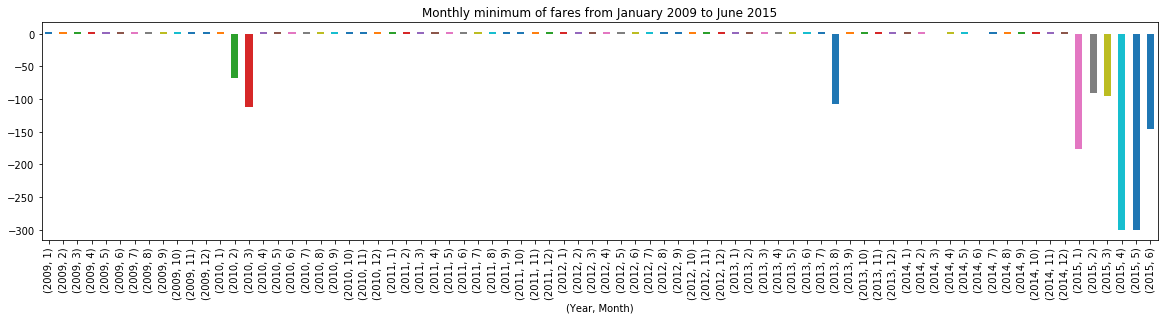

In [26]:
draw_barchart(fare_min_df, 'Monthly minimum of fares from January 2009 to June 2015')

Many minimum fare outliers fall in simply a few periods, such as February 2010, March 2010, August 2013, and January to June of 2015. 

Removing all rows with fare below \$.250 will remove those outliers.

## Monthly maximum fare

In [27]:
fare_max_df.describe()

count       78.000000
mean      3525.962402
std      15073.134766
min        199.300003
25%        371.250000
50%        450.000000
75%        499.742493
max      93963.359375
Name: fare_amount, dtype: float64

There are obviously some extreme values we need to get rid of before the statistics would make any sense.

The mean value of \$3526 for taxi ride is absurd.

Unlike minimum fare, we have no way of working out the optimal value for maximum fare.

Obviously, this is where the dependency with pickup and dropoff coordinates matters more - from where, to where, and how far you travel determines how much is the fare, instead of the date and time when you travel.

We rely more on visualization help from barchart.

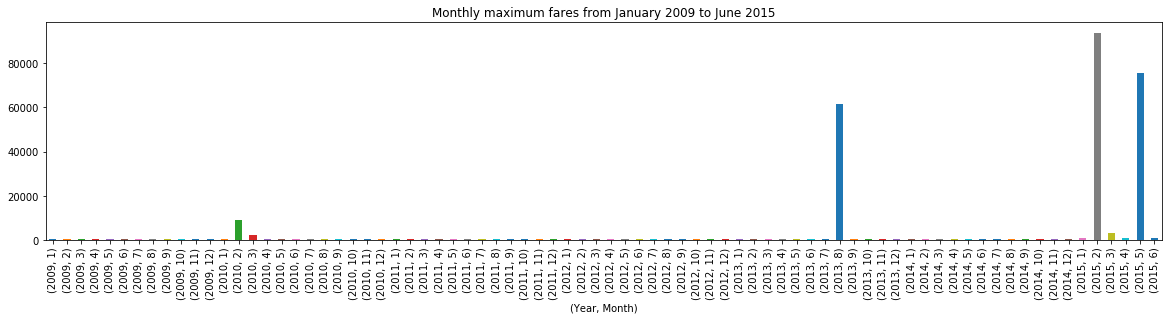

In [28]:
draw_barchart(fare_max_df, 'Monthly maximum fares from January 2009 to June 2015')

Luckily the chart above points shows us very clearly the few outliers that we should remove immediately.

Quite similar to the monthly minimum fare chart, there are outliers in the same periods, namely February 2010, 
March 2010, August 2013, and January to June of 2015 (more apparent in February and May).

We can sort the maximum monthly fare for easier observation.

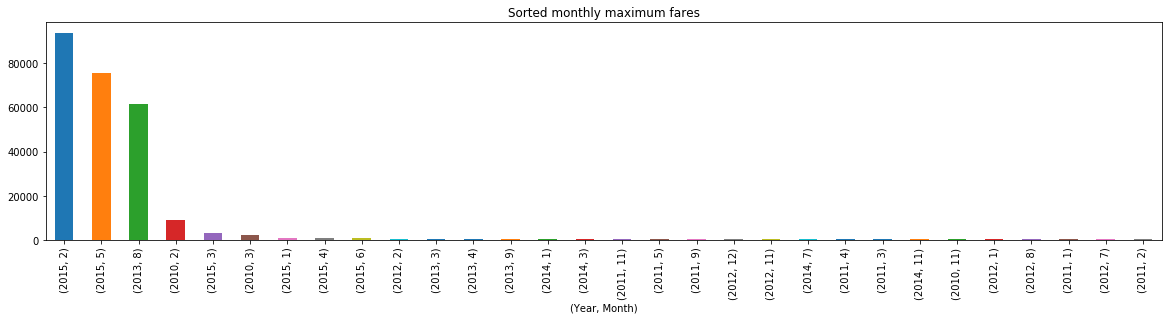

In [29]:
sorted_max_fare = fare_max_df.sort_values(ascending=False)
draw_barchart(sorted_max_fare.head(30), 'Sorted monthly maximum fares')

Seem that we only need to remove the first 9 elements in the list above. We can confirm by printing out the values.

In [30]:
sorted_max_fare.head(30)

pickup_datetime  pickup_datetime
2015             2                  93963.359375
                 5                  75747.023438
2013             8                  61550.859375
2010             2                   9000.410156
2015             3                   3130.300049
2010             3                   2023.699951
2015             1                    978.000000
                 4                    957.000000
                 6                    900.000000
2012             2                    500.000000
2013             3                    500.000000
                 4                    500.000000
                 9                    500.000000
2014             1                    500.000000
                 3                    500.000000
2011             11                   500.000000
                 5                    500.000000
                 9                    500.000000
2012             12                   500.000000
                 11                 

From the sorted values above, the 9th element has value of \$900. Thus we can safely remove those above **\$500.00** as outliers at this point.

This is better than just picking maximum value by gut feeling.

The maximum values of \$500.00 for taxi fare is still quite mind-boggling, but this is because we haven't considered the pickup-dropoff coordinates. It's most likely there are some extremely long taxi rides that we need to check.

# Summary Findings

1. By selectively choosing the columns/features during CSV file loading, we can reduce the memory usage of reading the **entire csv files of 55 million rows from 3Gb++ to less than 700Mb**.
1. By saving the raw dataframe to feather format, we can reload the entire dataframe in subsequent session much faster from a matter of **minutes to seconds**. There is no need to read the CSV file again.
1. Test data distribution is quite **different** from training data in terms of monthly total taxi rides. This is not my discovery, I derived from this [kernel](https://www.kaggle.com/akosciansky/using-ml-for-data-exploration-feat-engineering). This could affect how we create our validation data in order to maximize our test data score.
1. There is a jump in taxi fare by about \$2 to \$3 from September 2012. This matches the news report of [New York Taxis to Start Charging Increased Rates](https://www.nytimes.com/2012/09/04/nyregion/new-york-taxis-to-start-charging-increased-rates.html). We can create a boolean column to indicate whether the taxi charge is before or after the rate increase by checking the month and year.
1. From monthly minimum fare, there is a high occurence of **\$2.50**, which is the real minimum fare for NYC taxi ride.  Using this value is better than just simply removing rows with negative fare.
1. From monthly maximum fare, **\$500** is the reasonable cut-off point to remove outliers. To bring down this maximum value, we need to study the pickup and dropoff coordinates for both training and test data.
1. The outliers of maximum and minimum fare almost fall in the same periods of time - February 2010, March 2010, August 2013, and January to June of 2015 (more apparent in February and May).

# Todo

1. Remove outliers based on the findings above. See how much outliers we removed.
1. Revisit all the monthly group and aggregates after the previous step, see if we have cleaner data.
1. Explore other parts of datetime to see how is the fare affected by week of the year, day of the week and time of the day.
1. Consider adding a holiday or calendar events column to see if holiday or other events affect the taxi ride count.